# Predictive maintenance

## Part 2: Modeling

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1" 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import itertools

import numpy as np

import pylab as plt

import shap
    
import tensorflow as tf
from tensorflow import keras as K

import vaex
import vaex.ml
import vaex.ml.metrics
import vaex.ml.tensorflow

### Read in the data

In [2]:
df_train_full = vaex.open('./data/data_train.hdf5')
df_test = vaex.open('./data/data_test.hdf5')

###  Split the full training dataset into train and validation sets

In [3]:
# Train and validation split - validation is 5% of the full training data (in terms of engines)
# Randomly chose engine IDs to be part of the validation set.
# The validation set is 5% of the full training data (in terms of number of engines)
val_index = np.array([34, 70,  4, 71, 96])  # Fixed to ensure reproducibility
print('units part of the validation set:', val_index)

# Split on train and validation sets based on the val_index
df_train = df_train_full[~df_train_full.unit_number.isin(val_index)].extract()
df_val = df_train_full[df_train_full.unit_number.isin(val_index)].extract()

units part of the validation set: [34 70  4 71 96]


### Exploratory data analysis

In [4]:
# Get the sensor names
sensors = df_train.get_column_names()[5:-1]

# Curate a list of columns to drop
# Drop the settings - as they are not sensors to be monitored
cols_to_drop = ['setting_1', 'setting_2', 'setting_3']

# Remove sensors with constant or near constant values
cols_const = [s for s in sensors if df_train[s].nunique() < 5]
print('Columns with constant values:', cols_const)
cols_to_drop += cols_const

# Find Sensors that too weakly correlate with the RUL
cols_weak_corr_target = np.array(sensors)[np.array([np.abs(df_train.correlation(s, 'RUL')) for s in sensors]) < 0.01].tolist()
print('Columns too weakly correlating with the RUL:', cols_weak_corr_target)
cols_to_drop += cols_weak_corr_target

# Find highly correlated columns
# TODO - depending on the "new" correlation and mutual information API
# cols_high_corr = ['NRc']
# print('Highly correlated (> 0.95) columns:', cols_high_corr)
cols_to_corr = [s for s in sensors if s not in cols_to_drop]
cols_to_corr_pairs = list(itertools.combinations(cols_to_corr, 2))
d_tmp = {'col_a': [], 'col_b': [], 'corr': []}
for i in cols_to_corr_pairs:
    corr = df_train.correlation(i).item()
    d_tmp['col_a'].append(i[0])
    d_tmp['col_b'].append(i[1])
    d_tmp['corr'].append(corr)
df_corr = vaex.from_dict(d_tmp)
cols_high_corr = df_corr[np.abs(df_corr.corr) > 0.95].col_b.tolist()
print('Highly correlated (> 0.95) columns:', cols_high_corr)
cols_to_drop += cols_high_corr

# Remove duplicates from the list of columns to drop
cols_to_drop = sorted(list(set(cols_to_drop)))

print()
print('Final list of columns to drop:', cols_to_drop)

Columns with constant values: ['T2', 'P2', 'P15', 'epr', 'farB', 'Nf_dmd', 'PCNfR_dmd']
Columns too weakly correlating with the RUL: ['T2']
Highly correlated (> 0.95) columns: ['NRc']

Final list of columns to drop: ['NRc', 'Nf_dmd', 'P15', 'P2', 'PCNfR_dmd', 'T2', 'epr', 'farB', 'setting_1', 'setting_2', 'setting_3']


### Data preprocessing

- the Vaex way

In [5]:
# # Drop columns that are not needed
# df_train = df_train.drop(columns=cols_to_drop)

# Columns to MinMax scale
cols_to_scale = df_train.get_column_names()[2:-1]

# # Normalize in range (0, 1)
# df_train = df_train.ml.minmax_scaler(features=cols_to_scale)

# Normalize in range (0, 1)
df_train = df_train.ml.minmax_scaler(features=cols_to_scale, prefix='feat_')

# Get the scaled columns and from them create columns to be transformed into features
scaled_cols = df_train.get_column_names(regex='^feat')
for col in scaled_cols:
    feat_name = col.replace('feat', 'minmax_scaled')
    df_train[feat_name] = df_train[col].copy()


# Save the pipeline up to this point, to be used for visualising explanations via SHAP
df_train.pipeline.save('./model/pipeline_expl.json')

### Prepare the data such that it is suitable for LSTM input

LSTM layers require the data to be passed as sequences.

In [6]:
features = df_train.get_column_names(regex='^feat_')
features_to_reshape = features + ['RUL']
target = 'RUL_target'
sequence_length = 50
batch_size = 192

In [7]:
def reshape_data(df, groupby, shift_columns, sequence_length):
    '''Reshape the data to be suitable for LSTM input
    :param groupby: groupby the sequences by this column
    :param shift_columns: a list of columns to be shifted
    :sequence length: The length of each sequence. If a group has less samples than this number, it will be dropped.
    :return: The refshaped/transformed DataFrame
    '''
    return vaex.concat([df_tmp.shift(periods=(0, sequence_length), column=shift_columns, trim=True) for _, df_tmp in df.groupby(groupby) if len(df_tmp) > sequence_length])


# Apply the transformation to the DataFrame
df_train = df_train.transform(reshape_data, 
                              groupby='unit_number', 
                              shift_columns=features_to_reshape, 
                              sequence_length=sequence_length)


# Get the target value for each sequence
df_train['RUL_target'] = df_train.RUL[:, -1]

### Transform the vaidation set

Propagate the transformations done on the training set to the validation set in one line!

In [8]:
# Use the transformations of the train df and apply them to the validationd f
df_val_prep = df_train.pipeline.transform(df_val, trusted=True)

### Create data generators for training the Keras model

In [9]:
# Create generators to feed data into the Keras model
gen_train = df_train.ml.tensorflow.to_keras_generator(features=features, 
                                                      target=target, 
                                                      batch_size=batch_size, 
                                                      shuffle=False)

gen_val = df_val_prep.ml.tensorflow.to_keras_generator(features=features, 
                                                       target=target, 
                                                       batch_size=batch_size, 
                                                       shuffle=False)

Recommended "steps_per_epoch" arg: 78.0
Recommended "steps_per_epoch" arg: 5.0


### Define scoring metrics

In [10]:
def score_func(df, y_true, y_pred):
    print(f'mean absolute error: {np.round(df.ml.metrics.mean_absolute_error(y_true, y_pred), decimals=3)}')
    print(f'mean squared error: {np.round(df.ml.metrics.mean_squared_error(y_true, y_pred), decimals=3)}')
    print(f'R2 score: {np.round(df.ml.metrics.r2_score(y_true, y_pred), decimals=3)}')
    print()    
    
def r2_keras(y_true, y_pred):
    SS_res =  K.backend.sum(K.backend.square(y_true - y_pred))
    SS_tot = K.backend.sum(K.backend.square(y_true - K.backend.mean(y_true)))
    return (1 - SS_res/(SS_tot + K.backend.epsilon()))

### Define the model architecture & Train the model

In [11]:
def NN(seq_length, n_features, n_labels):
    
    # Input
    inp = K.layers.Input(shape=(sequence_length, n_features), name='Input')
    
    # Layers
    x = K.layers.LSTM(units=92, return_sequences=True, name='LSTM1')(inp)
    x = K.layers.SpatialDropout1D(rate=0.2)(x)
    x = K.layers.LSTM(units=48, return_sequences=False, name='LSTM2')(x)
    x = K.layers.Dropout(rate=0.2)(x)
    
    # The output layers
    x = K.layers.Dense(units=n_labels, activation=K.activations.linear, name='Output')(x)
    
    # This defines the NN Model, sets of inputs and outputs
    nn = K.models.Model(inputs=inp, outputs=x)
    
    
    # Compile the NN
    nn.compile(optimizer=K.optimizers.RMSprop(lr=0.01, decay=0.0005),
               loss=K.losses.MSE,
               metrics=[K.metrics.mae, K.metrics.mse, r2_keras])

    # Good luck!
    return nn

In [12]:
# Get and display the neural network model
nn = NN(seq_length=sequence_length, n_features=13, n_labels=1)

nn.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 50, 13)]          0         
_________________________________________________________________
LSTM1 (LSTM)                 (None, 50, 92)            39008     
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 92)            0         
_________________________________________________________________
LSTM2 (LSTM)                 (None, 48)                27072     
_________________________________________________________________
dropout (Dropout)            (None, 48)                0         
_________________________________________________________________
Output (Dense)               (None, 1)                 49        
Total params: 66,129
Trainable params: 66,129
Non-trainable params: 0
_________________________________________________________

In [13]:
# Callbacks
early      = K.callbacks.EarlyStopping(monitor='val_loss', patience=25, verbose=1, mode='min', min_delta=0.0001)
model_path = './model/rul_model.hdf5'
checkpoint = K.callbacks.ModelCheckpoint(model_path, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
decay      = K.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, mode='max', min_delta=0.001)

callback_list = [early, checkpoint, decay]

In [ ]:
# # Loads the full model - no need to define the architecture.
# nn = K.models.load_model(model_path, custom_objects={'r2_keras': r2_keras})

In [14]:
# Train the model 
history = nn.fit(x=gen_train, steps_per_epoch=78, epochs=101, verbose=1, 
                 validation_data=gen_val, validation_steps=5,
                 callbacks=callback_list)

# Get the best weights
nn.load_weights(model_path)

Epoch 1/101
78/78 [==============================] - 19s 207ms/step - loss: 7533.4305 - mean_absolute_error: 68.1142 - mean_squared_error: 7533.4305 - r2_keras: -2.0667 - val_loss: 7370.2124 - val_mean_absolute_error: 62.7569 - val_mean_squared_error: 7370.2124 - val_r2_keras: -1.3202
Epoch 2/101
78/78 [==============================] - 16s 202ms/step - loss: 4428.5711 - mean_absolute_error: 50.5830 - mean_squared_error: 4428.5711 - r2_keras: -0.6239 - val_loss: 5663.7075 - val_mean_absolute_error: 55.8303 - val_mean_squared_error: 5663.7075 - val_r2_keras: -2.0089
Epoch 3/101
78/78 [==============================] - 17s 214ms/step - loss: 3513.3765 - mean_absolute_error: 46.2410 - mean_squared_error: 3513.3765 - r2_keras: -0.2926 - val_loss: 5146.9844 - val_mean_absolute_error: 54.4545 - val_mean_squared_error: 5146.9844 - val_r2_keras: -2.8041
Epoch 4/101
78/78 [==============================] - 16s 210ms/step - loss: 3415.0966 - mean_absolute_error: 46.0580 - mean_squared_error: 341

78/78 [==============================] - 18s 224ms/step - loss: 1046.5000 - mean_absolute_error: 19.7607 - mean_squared_error: 1046.5000 - r2_keras: 0.6665 - val_loss: 2208.8838 - val_mean_absolute_error: 28.1036 - val_mean_squared_error: 2208.8840 - val_r2_keras: 0.4657
Epoch 56/101
78/78 [==============================] - 17s 212ms/step - loss: 1048.0850 - mean_absolute_error: 19.7051 - mean_squared_error: 1048.0850 - r2_keras: 0.6675 - val_loss: 2208.8838 - val_mean_absolute_error: 28.1036 - val_mean_squared_error: 2208.8838 - val_r2_keras: 0.4657

Epoch 00056: ReduceLROnPlateau reducing learning rate to 2.0479997697719911e-10.
Epoch 57/101
78/78 [==============================] - 17s 215ms/step - loss: 1039.3805 - mean_absolute_error: 19.7136 - mean_squared_error: 1039.3805 - r2_keras: 0.6673 - val_loss: 2208.8838 - val_mean_absolute_error: 28.1036 - val_mean_squared_error: 2208.8838 - val_r2_keras: 0.4657
Epoch 58/101
78/78 [==============================] - 18s 227ms/step - loss:

### Plot some training metrics

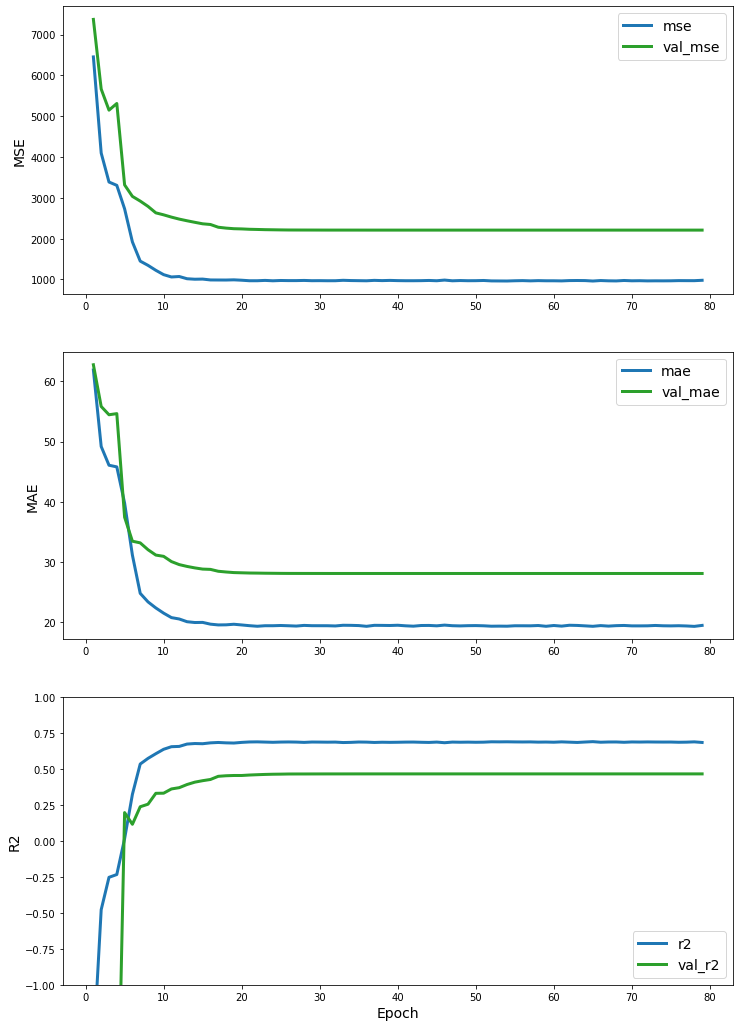

In [15]:
fig, axes = plt.subplots(nrows=3, ncols=1)
fig.set_size_inches(12, 18)
fs = 14

xvals = list(range(1, len(history.history['loss']) + 1))

axes[0].plot(xvals, history.history['loss'], label='mse', lw=3, color='C0')
axes[0].plot(xvals, history.history['val_loss'], label='val_mse', lw=3, color='C2')
axes[0].legend(fontsize=fs)
axes[0].set_ylabel('MSE', fontsize=fs)

axes[1].plot(xvals, history.history['mean_absolute_error'], label='mae', lw=3, color='C0')
axes[1].plot(xvals, history.history['val_mean_absolute_error'], label='val_mae', lw=3, color='C2')
axes[1].legend(fontsize=fs)
axes[1].set_ylabel('MAE', fontsize=fs)

axes[2].plot(xvals, history.history['r2_keras'], label='r2', lw=3, color='C0')
axes[2].plot(xvals, history.history['val_r2_keras'], label='val_r2', lw=3, color='C2')
axes[2].legend(fontsize=fs)
axes[2].set_xlabel('Epoch', fontsize=fs)
axes[2].set_ylabel('R2', fontsize=fs)
axes[2].set_ylim(-1, 1)

plt.show()

### Predict on the training set

In [16]:
# Serialize the keras model
keras_model = vaex.ml.tensorflow.KerasModel(features=features, 
                                            target=target, 
                                            model=nn, 
                                            custom_objects={'r2_keras': r2_keras})
df_train = keras_model.transform(df_train)
df_train['pred_value'] = df_train.keras_prediction[:, 0].round().astype('int')

# Evaluating with Keras is slow, so we materialize the final predicted column
df_train = df_train.materialize('pred_value')

print('Evaluation metrics on the training set')
score_func(df_train, 'RUL_target', 'pred_value')

Evaluation metrics on the training set
mean absolute error: 18.087
mean squared error: 906.624
R2 score: 0.717



### Evaluate on the validation set

In [17]:
# Save (serialize to a file) the entire transformation pipeline that is done on the training set so far
df_train.pipeline.save('model/pipeline.json')

# Load and propagate the transformation pipeline on the validation set! All in one step!
df_val_trans = df_val.pipeline.load_and_transform('model/pipeline.json', trusted=True)

# Preview the transformed test set!
df_val_trans

INFO:tensorflow:Assets written to: /tmp/tmpqjk3pgkh/assets


INFO:tensorflow:Assets written to: /tmp/tmpqjk3pgkh/assets


#,unit_number,time_in_cycles,RUL,minmax_scaled_T24,minmax_scaled_T30,minmax_scaled_T50,minmax_scaled_P30,minmax_scaled_Nf,minmax_scaled_Nc,minmax_scaled_Ps30,minmax_scaled_phi,minmax_scaled_NRf,minmax_scaled_BPR,minmax_scaled_htBleed,minmax_scaled_W31,minmax_scaled_W32,feat_Ps30,feat_T50,feat_htBleed,feat_W32,W31,feat_Nc,feat_T30,Nf,phi,feat_BPR,NRf,T50,BPR,T30,feat_NRf,Ps30,feat_W31,T24,feat_T24,W32,htBleed,feat_Nf,Nc,P30,feat_P30,feat_phi,RUL_target,keras_prediction,pred_value
0,4,1,"'masked_array(data=[188, 187, 186, 185, 184, 183...",0.41867469879518465,0.31305864399389777,0.34773801485482625,0.6634460547504115,0.2424242424240754,0.13178677196446525,0.2619047619047606,0.6929637526652539,0.27941176470602985,0.36590996537129816,0.4166666666666667,0.6976744186046505,0.6668072543230684,"'masked_array(data=[0.2619047619047606, 0.297619...","'masked_array(data=[0.34773801485482625, 0.47451...","'masked_array(data=[0.4166666666666667, 0.25, 0....","'masked_array(data=[0.6668072543230684, 0.754393...",39.04,"'masked_array(data=[0.13178677196446525, 0.11971...","'masked_array(data=[0.31305864399389777, 0.27250...",2388.06,521.94,"'masked_array(data=[0.36590996537129816, 0.28857...",2388.07,1402.85,8.42,1585.4,"'masked_array(data=[0.27941176470602985, 0.23529...",47.29,"'masked_array(data=[0.6976744186046505, 0.682170...",642.6,"'masked_array(data=[0.41867469879518465, 0.37349...",23.3814,393,"'masked_array(data=[0.2424242424240754, 0.242424...",9051.1,553.97,"'masked_array(data=[0.6634460547504115, 0.768115...","'masked_array(data=[0.6929637526652539, 0.641791...",139,"array([121.21059], dtype=float32)",121
1,4,2,"'masked_array(data=[187, 186, 185, 184, 183, 182...",0.3734939759036244,0.27250926531502,0.4745104659014162,0.7681159420289921,0.2424242424240754,0.11971641389213059,0.29761904761904767,0.6417910447761256,0.23529411764690147,0.28857252789534843,0.25,0.6821705426356613,0.7543933642626163,"'masked_array(data=[0.29761904761904767, 0.32738...","'masked_array(data=[0.4745104659014162, 0.276839...","'masked_array(data=[0.25, 0.25, 0.33333333333333...","'masked_array(data=[0.7543933642626163, 0.596513...",39.02,"'masked_array(data=[0.11971641389213059, 0.13838...","'masked_array(data=[0.27250926531502, 0.33900152...",2388.06,521.7,"'masked_array(data=[0.28857252789534843, 0.34667...",2388.04,1410.36,8.3999,1583.54,"'masked_array(data=[0.23529411764690147, 0.30882...",47.35,"'masked_array(data=[0.6821705426356613, 0.635658...",642.45,"'masked_array(data=[0.3734939759036244, 0.286144...",23.4437,391,"'masked_array(data=[0.2424242424240754, 0.272727...",9048.41,554.62,"'masked_array(data=[0.7681159420289921, 0.590982...","'masked_array(data=[0.6417910447761256, 0.567164...",138,"array([121.335075], dtype=float32)",121
2,4,3,"'masked_array(data=[186, 185, 184, 183, 182, 181...",0.286144578313238,0.3390015260518839,0.27683997299122365,0.5909822866344613,0.2727272727270848,0.13838284124562536,0.3273809523809507,0.567164179104478,0.30882352941189256,0.3466717968449389,0.25,0.6356589147286829,0.5965134261211837,"'masked_array(data=[0.3273809523809507, 0.321428...","'masked_array(data=[0.27683997299122365, 0.30503...","'masked_array(data=[0.25, 0.3333333333333333, 0....","'masked_array(data=[0.5965134261211837, 0.740475...",38.96,"'masked_array(data=[0.13838284124562536, 0.11653...","'masked_array(data=[0.3390015260518839, 0.281665...",2388.08,521.35,"'masked_array(data=[0.3466717968449389, 0.407849...",2388.09,1398.65,8.415,1586.59,"'masked_array(data=[0.30882352941189256, 0.19117...",47.4,"'masked_array(data=[0.6356589147286829, 0.565891...",642.16,"'masked_array(data=[0.286144578313238, 0.4578313...",23.3314,391,"'masked_array(data=[0.2727272727270848, 0.272727...",9052.57,553.52,"'masked_array(data=[0.5909822866344613, 0.600644...","'masked_array(data=[0.567164179104478, 0.7057569...",137,"array([121.17157], dtype=float32)",121
3,4,4,"'masked_array(data=[185, 184, 183, 182, 181, 180...",0.4578313253012081,0.2816655766296063,0.3050303

In [18]:
print('Evaluation metrics on the validation set')
score_func(df_val_trans, 'RUL_target', 'pred_value')

Evaluation metrics on the validation set
mean absolute error: 28.085
mean squared error: 2209.088
R2 score: 0.541



### Predict for one instance only

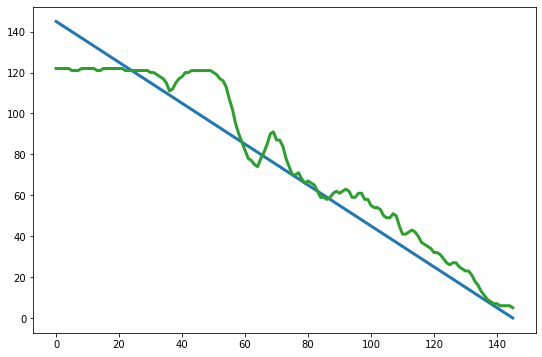

In [19]:
# Choose a unit number
unit_number = 34

df_one = df_val_trans[df_val_trans.unit_number == unit_number]
pred_one = df_one.pred_value.values
label_one = df_one.RUL_target.values

# Plot the result
xvals = list(range(label_one.shape[0]))
plt.figure(figsize=(9, 6))
plt.plot(xvals, label_one, lw=3, color='C0', label='Actual')
plt.plot(xvals, pred_one, lw=3, color='C2', label='Predicted')
plt.show()

### Getting the final prediction per unit

In [20]:
def prediction_post_processing(pred, N=5):
    '''Average the last N predictions of the series. If N=1, the prediction of the last step is returned.'''
    if N > pred.shape[0]:
        N = pred.shape[0]
    return (pred[-N:][::-1] - np.array(list(range(N)))).mean().round().astype(np.int)

Take the average of the last 5 predictions as the final prediction for a given engine.

In [21]:
def final_transformation(df, groupby, N=5):
    '''This does the final transformation to obtain the final RUL prediction for each engine.
    :param df: The dataframe on which to operate
    :param groupby: The column by which to group the sequences
    :param N: How many of the last sequences to use for the final averaging
    '''
    
    group_dict = {'unit_number': [],
                  'RUL_pred': [],
                  'RUL_gt': [],
                  'current_cycle': []}
    
    for _, df_tmp in df.groupby(by=groupby):
        group_dict['RUL_pred'].append(prediction_post_processing(df_tmp['pred_value'][:].values))
        group_dict['RUL_gt'].append(df_tmp.RUL_target.values[-1])
        group_dict['unit_number'].append(df_tmp.unit_number[:1].values[0])
        group_dict['current_cycle'].append(df_tmp.time_in_cycles.max().item())
    
    return vaex.from_dict(group_dict)


# The final DataFrame
df_train_final = df_train.transform(final_transformation, groupby='unit_number')

# Sort by unit number for better overview
df_train_final = df_train_final.sort('unit_number')

# Score the final on the training set
print('Score on the training set - final results!')
score_func(df_train_final, 'RUL_gt', 'RUL_pred')

Score on the training set - final results!
mean absolute error: 4.095
mean squared error: 17.147
R2 score: 0.0



In [22]:
# Save the the pipeline that leads to the final dataframe
df_train_final.pipeline.save('model/pipeline_final.json')

INFO:tensorflow:Assets written to: /tmp/tmpe_cb988n/assets


INFO:tensorflow:Assets written to: /tmp/tmpe_cb988n/assets


### Apply the full transformation to the validation set

In [23]:
# The full transformation!
df_val_final = df_val.pipeline.load_and_transform('model/pipeline_final.json', trusted=True)

# See the validation set
df_val_final

#,unit_number,RUL_pred,RUL_gt,current_cycle
0,4,4,0,140
1,34,4,0,146
2,70,4,0,88
3,71,4,0,159
4,96,4,0,287


In [24]:
print('Score on the training set - final results!')
score_func(df_val_final, 'RUL_gt', 'RUL_pred')

Score on the training set - final results!
mean absolute error: 4.0
mean squared error: 16.0
R2 score: 0.0



### Plot a sensor

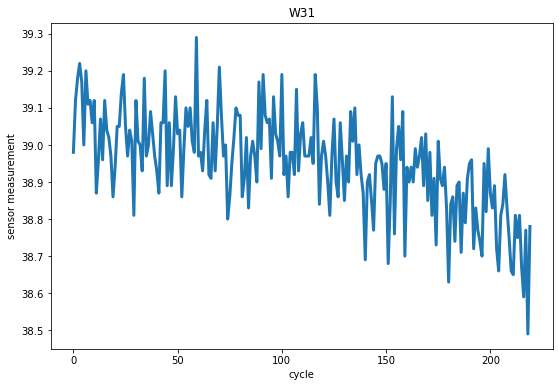

In [25]:
unit_number = 5
sensor_name = 'W31'
sensor_values = df_train[df_train.unit_number == unit_number][sensor_name].values

xvals = plt.array(range(sensor_values.shape[0]))
plt.figure(figsize=(9, 6))
plt.plot(xvals, sensor_values, lw='3', color='C0')
plt.xlabel('cycle')
plt.ylabel('sensor measurement')
plt.title(sensor_name)
plt.show()

### Explanations via `SHAP`

In [26]:
df_train_background = df_train[features_to_reshape].sample(n=2000, replace=False, random_state=42)
bg_seq_array = df_train_background[features].values.transpose(1, 0, 2).data
np.save(file='model/bg_seq_array_data.npy', arr=bg_seq_array)

# Instantiate the explainer with the specific background and model
explainer = shap.GradientExplainer(model=nn, data=bg_seq_array)

In [27]:
def prepare_to_explain_one(unit_number=31):
    df_tmp = df_train[df_train.unit_number == unit_number]
    seq_one = df_train[features][-1:].values.transpose(1, 0, 2).data
    return seq_one

# Explain one sequence
seq_to_explain = prepare_to_explain_one(unit_number=21)

Plot the feature importance for this particular sample engine

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


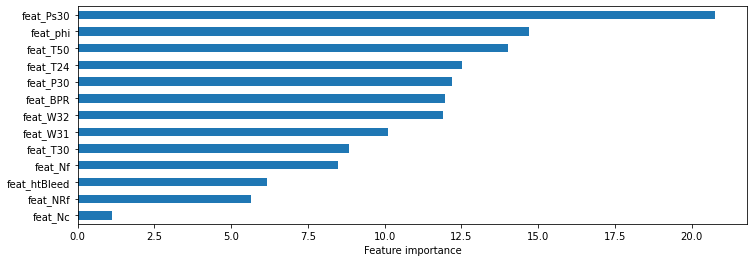

In [28]:
import pandas as pd  # for plotting convenience

# Feature importance for one sample prediction
shap_values = explainer.shap_values(seq_to_explain)[0]
expl = np.abs(shap_values[0]).sum(axis=0)

s = pd.Series(data=expl, index=features)
s.sort_values().plot.barh(figsize=(12, 4));
plt.xlabel('Feature importance');

Get the relevance for each cycle in the sequence, per sensor. Gives us a sense which sensor readings had the most weight during the decision making process by the neural network.

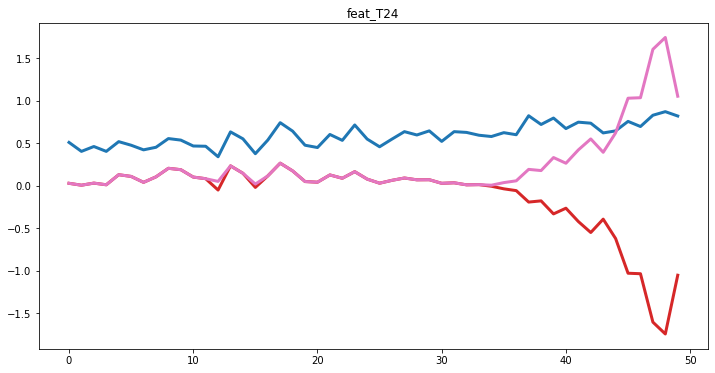

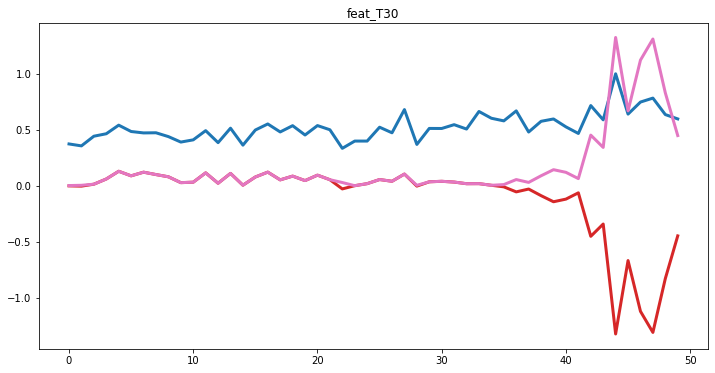

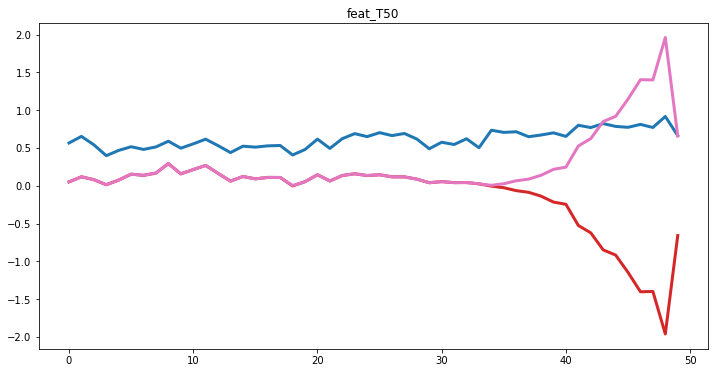

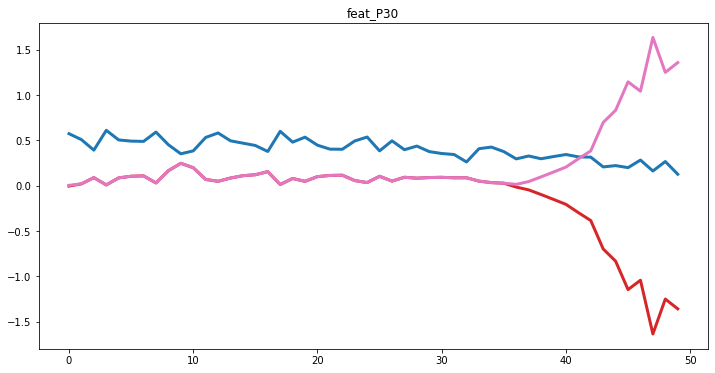

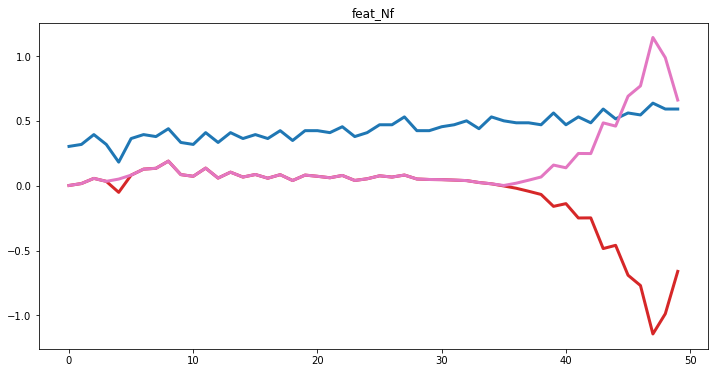

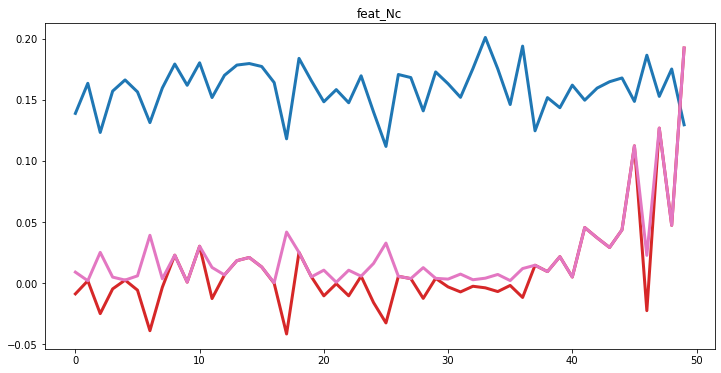

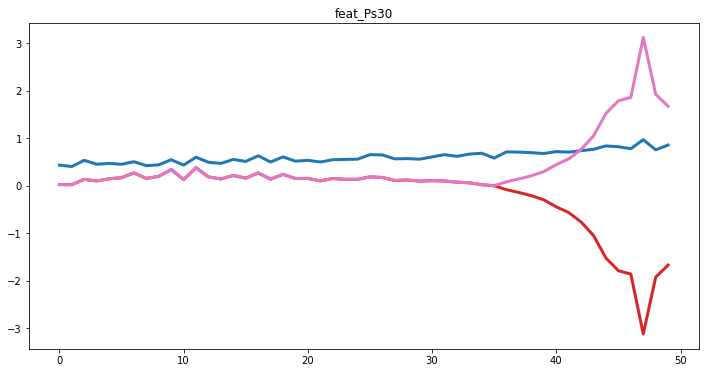

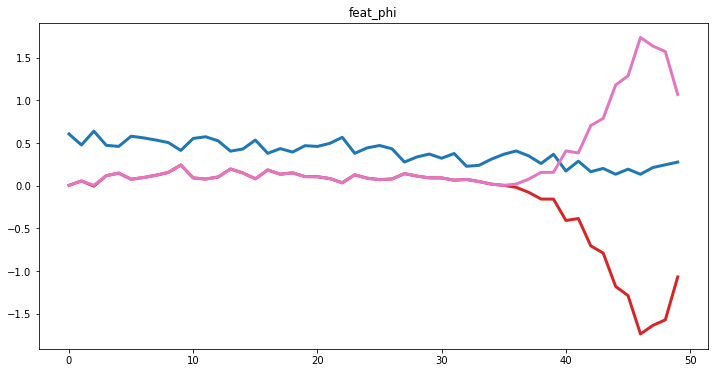

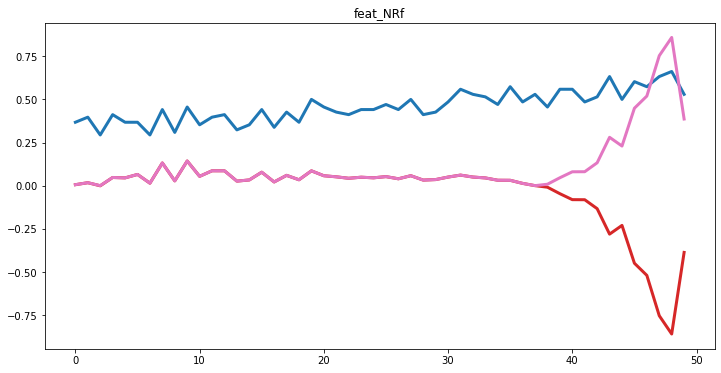

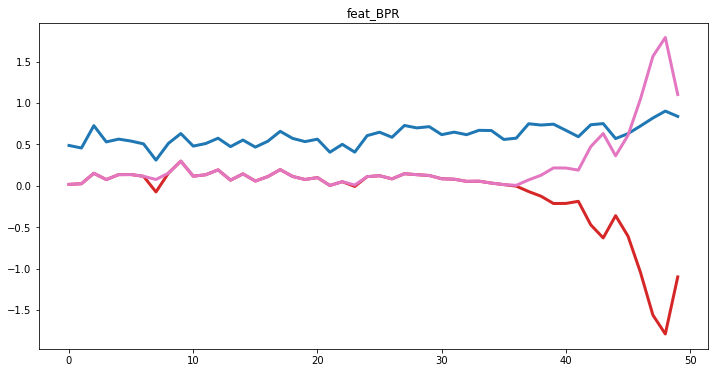

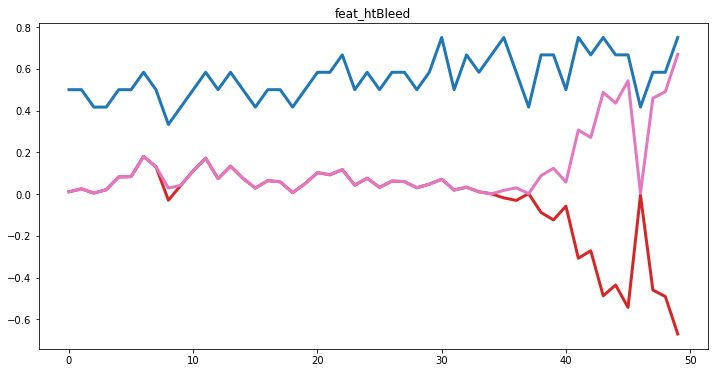

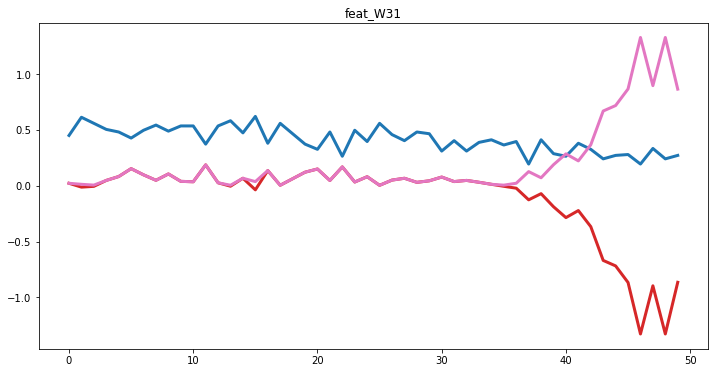

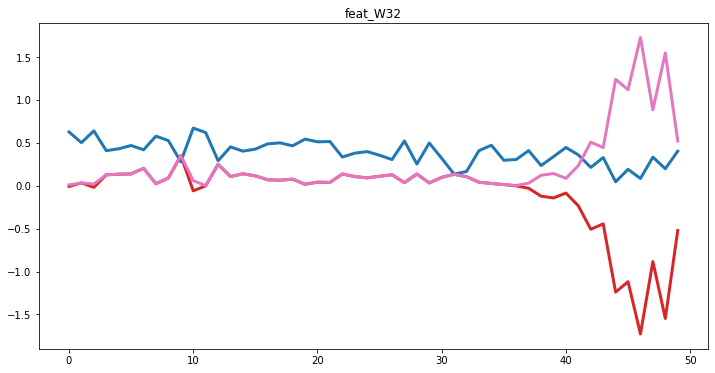

In [29]:
for i, v in enumerate(features):
    plt.figure(figsize=(12, 6))
    plt.title(v)
    plt.plot(seq_to_explain[0, :, i], lw=3, color='C0')
    plt.plot(shap_values[0, :, i], lw=3, color='C3')
    plt.plot(np.abs(shap_values[0, :, i]), lw=3, color='C6')
    plt.show()

This is the end of the modelling part. See the "production" part next!